# Visualizing Convolutional Networks
modify from [DeepLearningImplementations](https://github.com/tdeboissiere/DeepLearningImplementations)

### 1.Load VGG16 Model

In [1]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
import numpy as np


def VGG_16(weights_path=None):
    """
    VGG Model Keras specification

    args: weights_path (str) trained weights file path

    returns model (Keras model)
    """

    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        print "Loading weights..."
        model.load_weights(weights_path)

    return model

def load_model(weights_path):
    """
    Load and compile VGG model

    args: weights_path (str) trained weights file path

    returns model (Keras model)
    """

    model = VGG_16(weights_path)
    model.compile(optimizer="sgd", loss='categorical_crossentropy')
    return model

model = load_model('./vgg16_weights.h5')
for l in model.layers:
    if "convolution2d"in l.name:
        print l.name + " - " + str(l.get_weights()[0].shape)
    else:
        print l.name

Using Theano backend.
Using gpu device 3: Graphics Device (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 2000.)


Loading weights...
zeropadding2d_1
convolution2d_1 - (64, 3, 3, 3)
zeropadding2d_2
convolution2d_2 - (64, 64, 3, 3)
maxpooling2d_1
zeropadding2d_3
convolution2d_3 - (128, 64, 3, 3)
zeropadding2d_4
convolution2d_4 - (128, 128, 3, 3)
maxpooling2d_2
zeropadding2d_5
convolution2d_5 - (256, 128, 3, 3)
zeropadding2d_6
convolution2d_6 - (256, 256, 3, 3)
zeropadding2d_7
convolution2d_7 - (256, 256, 3, 3)
maxpooling2d_3
zeropadding2d_8
convolution2d_8 - (512, 256, 3, 3)
zeropadding2d_9
convolution2d_9 - (512, 512, 3, 3)
zeropadding2d_10
convolution2d_10 - (512, 512, 3, 3)
maxpooling2d_4
zeropadding2d_11
convolution2d_11 - (512, 512, 3, 3)
zeropadding2d_12
convolution2d_12 - (512, 512, 3, 3)
zeropadding2d_13
convolution2d_13 - (512, 512, 3, 3)
maxpooling2d_5
flatten_1
dense_1
dropout_1
dense_2
dropout_2
dense_3


### 2.Functions

In [2]:
import cv2
import keras.backend as K

def deconv(model, target_layer, feat_map, im):
    dlayers = {}
    for l in model.layers:
        dlayers[l.name] = l
    layerNames = [l.name for l in model.layers]

    im = im.reshape((1,) + im.shape)
    symX = K.T.tensor4('x')
    ##%%%%%%%%%%%%%%%%%%%%%%#
    # forward pass
    ##%%%%%%%%%%%%%%%%%%%%%%#
    X_foward = im
    d_switch = {}
    layer_index = layerNames.index(target_layer)

    for lname in layerNames[:layer_index+1]:
        # print('forwarding {} ...'.format(lname))
        T_in, T_out = dlayers[lname].input, dlayers[lname].output

        forward = K.function([T_in], T_out)
        X_foward = forward([X_foward])
        # Record the switch variables
        if "convolution2d" in lname:
            d_switch[lname] = np.where(X_foward <= 0)

    ##%%%%%%%%%%%%%%%%%%%%%%#
    # backward pass
    ##%%%%%%%%%%%%%%%%%%%%%%#
    X_outlayer = X_foward
    # print "*************Deconvolution*************"
    # print "Deconvolving %s ..." % target_layer
    if "maxpooling2d" in target_layer:
        print 'you wanna to see maximal activations in pooling layers?'

    elif "convolution2d" in target_layer:

        output_width, output_height = dlayers[target_layer].output_shape[-2:]
        filter_width, filter_height = dlayers[target_layer].W_shape[2], dlayers[target_layer].W_shape[3]

        # Compute padding needed
        input_width, input_height = X_outlayer.shape[-2:]
        pad_width = (output_width - input_width + filter_width - 1) / 2
        pad_height = (output_height - input_height + filter_height - 1) / 2
        assert isinstance(pad_width, int), "Pad width size issue at layer %s" % lname
        assert isinstance(pad_height, int), "Pad height size issue at layer %s" % lname
        
        # using switch which recorded from forward pass
        X_outlayer[d_switch[target_layer]] = 0
        activation = dlayers[target_layer].activation
        # relu
        X_outlayer = activation(X_outlayer)

        # For the first output layer, choose only maxima activation (point) on the feature map
        ## Setting other feature maps to zero
        list_feat_map = np.arange(X_outlayer.shape[1]).tolist()
        list_feat_map.remove(feat_map)
        X_outlayer[:, list_feat_map, :, :] = 0

        ## Setting other points to zero
        for i in range(X_outlayer.shape[0]):
            iw, ih = np.unravel_index(X_outlayer[i, feat_map, :, :].argmax(), X_outlayer[i, feat_map, :, :].shape)
            maxActivationValue = np.max(X_outlayer[i, feat_map, :, :])
            X_outlayer[i, feat_map, :, :] = 0
            X_outlayer[i, feat_map, iw, ih] = maxActivationValue

        W = dlayers[target_layer].W
        W = W.transpose([1,0,2,3])
        W = W[:,:, ::-1, ::-1]

        conv_out = K.T.nnet.conv2d(input=symX, filters=W, border_mode='valid')
        pad = K.function([symX], K.spatial_2d_padding(symX, padding=(pad_width, pad_height), dim_ordering="th"))
        X_pad = pad([X_outlayer])

        deconv_func = K.function([symX], conv_out)
        X_deconv = deconv_func([X_pad])
        assert X_deconv.shape[-2:]==(output_width, output_height), "Deconv output at {} has wrong size".format(target_layer)

    else:
        raise ValueError('Invalid layer name {}'.format(target_layer))       

    # Iterate remining layers until to input
    X_outlayer = X_deconv
    for lname in layerNames[:layer_index][::-1]:
        # print "Deconvolving {} ...".format(lname)
        # Unpool
        if "maxpooling2d" in lname:
            p1, p2 = dlayers[lname].pool_size
            uppool = K.function([symX], K.resize_images(symX, p1, p2, "th"))
            X_outlayer = uppool([X_outlayer])
        # deconvolution
        elif "convolution2d" in lname:
            output_width, output_height = dlayers[lname].output_shape[-2:]
            filter_width = dlayers[lname].W_shape[2]
            filter_height = dlayers[lname].W_shape[3]

            # Compute padding needed
            input_width, input_height = X_outlayer.shape[-2:]
            pad_width = (output_width - input_width + filter_width - 1) / 2
            pad_height = (output_height - input_height + filter_height - 1) / 2
            assert isinstance(pad_width, int), "Pad width size issue at layer %s" % lname
            assert isinstance(pad_height, int), "Pad height size issue at layer %s" % lname

            X_outlayer[d_switch[lname]] = 0
            activation = dlayers[lname].activation
            X_outlayer = activation(X_outlayer)

            W = dlayers[lname].W
            W = W.transpose([1,0,2,3])
            W = W[:,:, ::-1, ::-1]

            conv_out = K.T.nnet.conv2d(input=symX, filters=W, border_mode='valid')
            pad = K.function([symX], K.spatial_2d_padding(symX, padding=(pad_width, pad_height), dim_ordering="th"))
            X_pad = pad([X_outlayer])

            deconv_func = K.function([symX], conv_out)
            X_deconv = deconv_func([X_pad])
            assert X_deconv.shape[-2:]==(output_width, output_height), "Deconv output at {} has wrong size".format(lname)
            X_outlayer = X_deconv
        elif "padding" in lname:
                pass
        else:
            raise ValueError("Invalid layer name: {}".format(lname))
            
    return X_outlayer

def loadImage(path):
    im = cv2.resize(cv2.imread(imPath), (224, 224)).astype(np.float32)
    imOri = im.copy()
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68
    im = im.transpose((2,0,1))
    return im, imOri

def normalize(arg):
    arg = arg[0]
    minValue = arg.min()
    maxValue = arg.max()
    imNorm = (arg - minValue) / (maxValue-minValue)
    return imNorm.transpose((1,2,0))

### 3.Visualizing

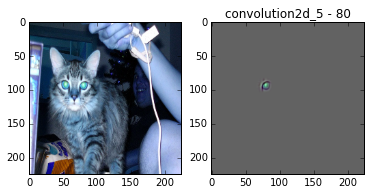

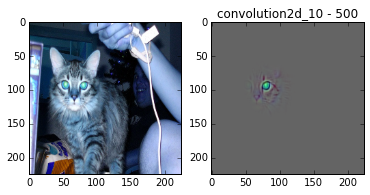

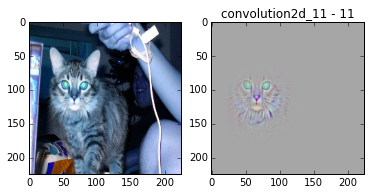

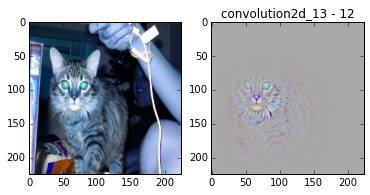

In [3]:
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

# choose 4 feature maps to visualize
feat_dict = OrderedDict()
feat_dict["convolution2d_5"] = 80
feat_dict["convolution2d_10"] = 500
feat_dict["convolution2d_11"] = 11
feat_dict["convolution2d_13"] = 12

# Load data
imPath = './Data/001001.jpg'
im, imOri = loadImage(imPath)

for k,v in feat_dict.items():
    target_layer = k
    feat_map = v
    output = deconv(model, target_layer, feat_map, im)

    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(imOri/255.)
    plt.subplot(1,2,2)
    plt.imshow(normalize(output))
    plt.title(target_layer+" - "+str(feat_map))
    plt.show()

### 4.Another area of input image that the feature map is looking for

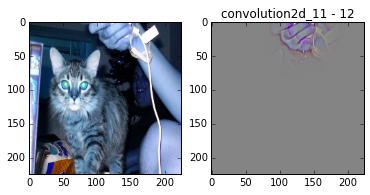

In [4]:
target_layer = "convolution2d_11"
feat_map = 12
output = deconv(model, target_layer, feat_map, im)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(imOri/255.)
plt.subplot(1,2,2)
plt.imshow(normalize(output))
plt.title(target_layer+" - "+str(feat_map))

## Investigate the Fully Connected Layers

In [5]:
def defc(model, target_layer, class_index, im):
    dlayers = {}
    for l in model.layers:
            dlayers[l.name] = l

    LayerNames = [l.name for l in model.layers]
    targetLayer = target_layer
    layer_index = LayerNames.index(targetLayer)
    d_switch = {}
    X_foward = im
    X_foward = X_foward.reshape((1,)+X_foward.shape)
    for lname in LayerNames[:layer_index+1]:
        # print lname
        if 'dropout' in lname:
            X_foward = (1-dlayers[lname].p) * X_foward
        else:
            T_in, T_out = dlayers[lname].input,dlayers[lname].output 
            forward = K.function([T_in], T_out)
            X_foward = forward([X_foward])
        if "convolution2d" in lname:
                d_switch[lname] = np.where(X_foward <= 0)

    # backward pass
    symX = K.T.tensor4('xt')
    symXMatrix = K.T.matrix('xm')

    # maxActivationIndex = np.argmax(X_foward)  # dense layer
    print 'maxActivationIndex:', np.argmax(X_foward)
    maxActivationIndex = class_index
    oneActVector = np.arange(X_foward.shape[1]).tolist() 
    oneActVector.remove(maxActivationIndex)
    X_foward[:,oneActVector] = 0

    X_outlayer = X_foward
    for lname in LayerNames[:layer_index+1][::-1]:
        # print 'backward pass ... ' , lname
        if 'dropout' in lname:
            pass
        elif 'dense' in lname:
            W = dlayers[lname].W
            W = W.transpose((1,0))   # transpose W
            forward = K.function([symXMatrix], K.dot(symXMatrix, W))

            X_outlayer = forward([X_outlayer])

        elif 'flatten' in lname:
            input_shape, output_shape = dlayers[lname].input_shape[1:], dlayers[lname].output_shape[1:]
            input_shape = (X_foward.shape[0],) + input_shape
            output_shape = (X_foward.shape[0],) + output_shape
            # print input_shape, output_shape
            reshape = K.function([symXMatrix], K.reshape(symXMatrix, input_shape))

            X_outlayer = reshape([X_outlayer])

        elif "maxpooling2d" in lname:
            p1, p2 = dlayers[lname].pool_size
            uppool = K.function([symX], K.resize_images(symX, p1, p2, "th"))

            X_outlayer = uppool([X_outlayer])

        # deconvolution
        elif "convolution2d" in lname:
            output_width, output_height = dlayers[lname].output_shape[-2:]
            filter_width = dlayers[lname].W_shape[2]
            filter_height = dlayers[lname].W_shape[3]

            # Compute padding needed
            input_width, input_height = X_outlayer.shape[-2:]
            pad_width = (output_width - input_width + filter_width - 1) / 2
            pad_height = (output_height - input_height + filter_height - 1) / 2
            assert isinstance(pad_width, int), "Pad width size issue at layer %s" % lname
            assert isinstance(pad_height, int), "Pad height size issue at layer %s" % lname

            X_outlayer[d_switch[lname]] = 0
            activation = dlayers[lname].activation
            X_outlayer = activation(X_outlayer)

            W = dlayers[lname].W
            W = W.transpose([1,0,2,3])
            W = W[:,:, ::-1, ::-1]

            conv_out = K.T.nnet.conv2d(input=symX, filters=W, border_mode='valid')
            pad = K.function([symX], K.spatial_2d_padding(symX, padding=(pad_width, pad_height), dim_ordering="th"))
            X_pad = pad([X_outlayer])

            deconv_func = K.function([symX], conv_out)
            X_deconv = deconv_func([X_pad])
            assert X_deconv.shape[-2:]==(output_width, output_height), "Deconv output at {} has wrong size".format(lname)
            X_outlayer = X_deconv
            
    return X_outlayer

### 282 is the line number of "n02123045 tabby, tabby cat" in "synset_words.txt" of "caffe_ilsvrc12.tar.gz"

maxActivationIndex: 263


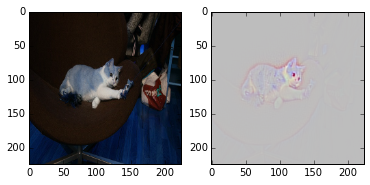

In [6]:
# Load data
imPath = './Data/000044.jpg'
im, imOri = loadImage(imPath)

X_outlayer = defc(model, 'dense_3', 282, im)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(imOri/255.)
plt.subplot(1,2,2)
plt.imshow(normalize(X_outlayer))
plt.show()

maxActivationIndex: 285


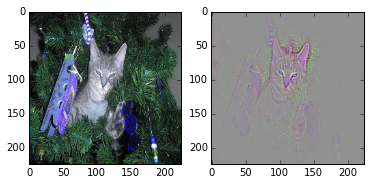

In [7]:
imPath = './Data/000528.jpg'
im, imOri = loadImage(imPath)

X_outlayer = defc(model, 'dense_3', 282, im)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(imOri/255.)
plt.subplot(1,2,2)
plt.imshow(normalize(X_outlayer))
plt.show()